In [2]:
# !pip install opencv-python moviepy

8/8 [==============================] - 0s 2ms/step


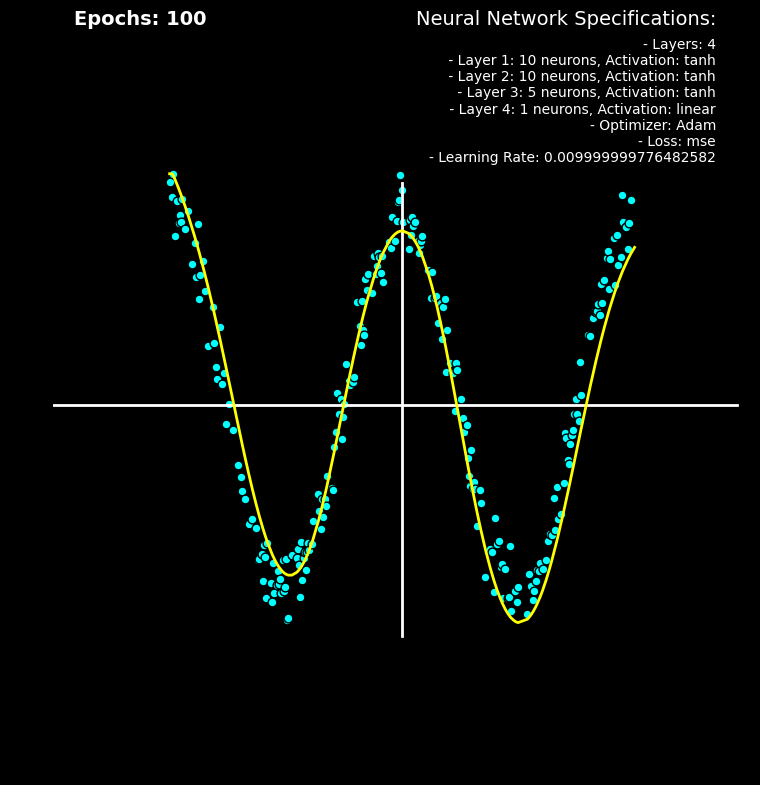

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Global variable for distribution amplitude
distribution_amplitude = 0.2

# Generate synthetic data resembling a simple cosine function with noise and gaps
np.random.seed(0)
X = np.linspace(-2 * np.pi, 2 * np.pi, 400)
y = distribution_amplitude * np.cos(X) + (distribution_amplitude / 10) * np.random.randn(400)
drop_indices = np.random.choice(len(X), size=150, replace=False)
X = np.delete(X, drop_indices).reshape(-1, 1)
y = np.delete(y, drop_indices)

# Create a simple neural network model
model = Sequential([
    Dense(10, input_dim=1, activation='tanh'),
    Dense(10, activation='tanh'),
    Dense(5, activation='tanh'),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')

# Custom callback to capture model weights after each epoch
class CaptureWeights(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.weights = []

    def on_epoch_end(self, epoch, logs=None):
        self.weights.append(self.model.get_weights())

capture_weights = CaptureWeights()

# Train the model and capture weights
model.fit(X, y, epochs=100, verbose=0, callbacks=[capture_weights])

# Calculate the amplitude for adaptive axis spines
amplitude = np.max(np.abs(y))

# Set up the plot with black background and black facecolor
fig, ax = plt.subplots(figsize=(9, 9), facecolor='black')
ax.set_xlim(-3 * np.pi, 3 * np.pi)
ax.set_ylim(-amplitude * 1.5, amplitude * 1.5)
ax.set_facecolor('black')

# Hide the default x and y axis
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')

# Initialize empty line objects for custom axes
x_axis_line, = ax.plot([], [], color='white', linewidth=2)
y_axis_line, = ax.plot([], [], color='white', linewidth=2)

# Initialize empty scatter plot for data points
scatter = ax.scatter([], [], c='aqua', edgecolors='black', linewidth=1, s=40, label='Data')

# Initialize empty line plot for model predictions
line, = ax.plot([], [], color='yellow', lw=2, label='Prediction')

# Function to get model specifications
def get_model_specs(model):
    specs = ""
    specs += f"- Layers: {len(model.layers)}\n"
    for i, layer in enumerate(model.layers):
        specs += f" - Layer {i+1}: {layer.units} neurons, Activation: {layer.activation.__name__}\n"
    specs += f"- Optimizer: {model.optimizer.__class__.__name__}\n"
    specs += f"- Loss: {model.loss}\n"
    specs += f"- Learning Rate: {model.optimizer.learning_rate.numpy()}\n"
    return specs

# Function to update the plot for each frame in the animation
def animate(i):
    if i < 50:  # Animate x-axis
        x_axis_line.set_data([-3 * np.pi, -3 * np.pi + (6 * np.pi) * (i / 50)], [0, 0])
    elif i < 100:  # Animate y-axis
        y_axis_line.set_data([0, 0], [-amplitude, -amplitude + (2 * amplitude) * ((i - 50) / 50)])
    elif i < 350:  # Scatter data points one by one
        num_points_to_show = i - 100
        if num_points_to_show > len(X):
            num_points_to_show = len(X)
        scatter.set_offsets(np.c_[X[:num_points_to_show], y[:num_points_to_show]])
    else:  # Animate learning line and update text
        total_frames = len(capture_weights.weights) * 5  # Interpolate for smoother animation
        epoch_index = (i - 350) // 5
        weight_alpha = ((i - 350) % 5) / 5.0

        # Interpolate between weights for smooth transition
        if epoch_index < len(capture_weights.weights) - 1:
            weights = []
            for w1, w2 in zip(capture_weights.weights[epoch_index], capture_weights.weights[epoch_index + 1]):
                weights.append(w1 * (1 - weight_alpha) + w2 * (weight_alpha))
            model.set_weights(weights)
        else:
            model.set_weights(capture_weights.weights[-1])

        y_pred = model.predict(X)
        y_pred = np.clip(y_pred, -amplitude, amplitude)  # Constrain predictions within plot area
        line.set_data(X, y_pred)

        # Update network specifications with epoch count
        specs_text.set_text(get_model_specs(model))
        specs_text_epoch.set_text(f"Epochs: {epoch_index + 1}")

    return line, scatter, specs_text, specs_text_epoch, x_axis_line, y_axis_line

# Display initial network specifications and epoch count
specs_text_title = plt.text(0.95, 1.07, "Neural Network Specifications:", fontsize=14, color='white', ha='right', va='top', transform=ax.transAxes)
specs_text = plt.text(0.95, 1.03, get_model_specs(model), fontsize=10, color='white', ha='right', va='top', transform=ax.transAxes)
specs_text_epoch = plt.text(0.03, 1.07, "Epochs: 0", fontsize=14, color='white', ha='left', va='top', transform=ax.transAxes, fontweight='bold')

# Create animation
ani = FuncAnimation(fig, animate, frames=350 + len(capture_weights.weights) * 5, interval=50, blit=True)

# Save the animation
writer = FFMpegWriter(fps=20, metadata=dict(artist='Me'), bitrate=1800)
ani.save("neural_network_cosine_fit.mp4", writer=writer)

plt.show()
